In [1]:
# load faces and resize them - since efficient net cant be used images can be smaller to fit the
# entire net on home GPU
import glob
from PIL import Image

for filename in glob.glob('224_FACES/*'):
    with Image.open(filename) as im:
        im = im.resize((112, 112))
        filename = filename.split('\\')[1]
        im.save("112faces\\" + filename )
    # break

In [2]:
from os import listdir
from numpy import asarray
from numpy import savez_compressed
from PIL import Image
from matplotlib import pyplot
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.layers import (
    Input,
    Dense,
    Reshape,
    Flatten,
    Dropout,
    multiply,
    GaussianNoise,
    Conv2D,
    Conv2DTranspose,
    LeakyReLU,
)
from tensorflow.keras.layers import (
    BatchNormalization,
    Activation,
    Embedding,
    ZeroPadding2D,
)
from tensorflow.keras.layers import MaxPooling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

dir = "C:\\Users\\michal\\Desktop\\UTKFace\\112faces\\"
file = "C:\\Users\\michal\Desktop\\UTKFace\\faces.txt"

dir_contents = [filename for filename in listdir(dir)]

main_list = []

for filename in dir_contents:
    tmp = int(filename.split("_")[0])

    ages = [age for age in range(10, 110, 10)]
    ages.append(200)
    strs = ['0-10',
            '10-20',
            '20-30',
            '30-40',
            '40-50',
            '50-60',
            '60-70', '70-80', '80-90', '90-100', '100+']

    for age, stra in zip(ages, strs):
        if tmp < age:
            tmp = f"{stra}_old"
            break


    main_list.append((tmp, filename))


print(main_list[:10])

df = pd.DataFrame(data=main_list, columns=["label", "image"])

print(df.head())

print(df.tail())


[('100+_old', '100_0_0_20170112213500903.jpg'), ('100+_old', '100_0_0_20170112215240346.jpg'), ('100+_old', '100_1_0_20170110183726390.jpg'), ('100+_old', '100_1_0_20170112213001988.jpg'), ('100+_old', '100_1_0_20170112213303693.jpg'), ('100+_old', '100_1_0_20170112215032192.jpg'), ('100+_old', '100_1_0_20170117195420803.jpg'), ('100+_old', '100_1_0_20170119212053665.jpg'), ('100+_old', '100_1_2_20170105174847679.jpg'), ('100+_old', '100_1_2_20170112213615815.jpg')]
      label                          image
0  100+_old  100_0_0_20170112213500903.jpg
1  100+_old  100_0_0_20170112215240346.jpg
2  100+_old  100_1_0_20170110183726390.jpg
3  100+_old  100_1_0_20170112213001988.jpg
4  100+_old  100_1_0_20170112213303693.jpg
          label                        image
23495  0-10_old  9_1_3_20161220222856346.jpg
23496  0-10_old  9_1_3_20170104222949455.jpg
23497  0-10_old  9_1_4_20170103200637399.jpg
23498  0-10_old  9_1_4_20170103200814791.jpg
23499  0-10_old  9_1_4_20170103213057382.jpg


In [3]:
# Let's check how many samples for each category are present
print("Total number of images in the dataset: ", len(df))

label_count = df['label'].value_counts()
print(label_count)

Total number of images in the dataset:  23500
20-30_old     7344
30-40_old     4329
0-10_old      3062
50-60_old     2299
40-50_old     2245
10-20_old     1531
60-70_old     1318
70-80_old      699
80-90_old      504
90-100_old     137
100+_old        32
Name: label, dtype: int64


In [4]:
#mage augmentation, not used since augmentated dataset was too big to fit on 16GB RAM
from scipy.ndimage import rotate

def rotate_img(img, angle=45, bg_patch=(5,5)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    else:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img

def gaussian_noise(img, mean=0, sigma=0.03):
    img = img.copy()
    noise = np.random.normal(mean, sigma, img.shape)
    mask_overflow_upper = img+noise >= 1.0
    mask_overflow_lower = img+noise < 0
    noise[mask_overflow_upper] = 1.0
    noise[mask_overflow_lower] = 0
    img = img.astype("float64")
    img += noise
    return img

In [5]:
import cv2

images = []
labels = []

ages = [age for age in range(10, 110, 10)]
ages.append(200)
strs = ['0-10',
        '10-20',
        '20-30',
        '30-40',
        '40-50',
        '50-60',
        '60-70', '70-80', '80-90', '90-100', '100+']

for filename in listdir(dir):
    img = cv2.imread(dir + filename)
    images.append(img)

    tmp = int(filename.split("_")[0])

    for age, stra in zip(ages, strs):
        if tmp < age:
            tmp = f"{stra}_old"
            break
    # print(tmp)
    labels.append(tmp)

    # rotated = rotate_img(img)
    # noised = gaussian_noise(img)
    # images.append(rotated)
    # images.append(noised)

    # labels.append(tmp)
    # labels.append(tmp)

images = np.array(images)
images = images.astype('float32') / 255.0

print(images.shape)

(23500, 112, 112, 3)


In [6]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=df['label'].values
print(y)

lbls = set(y)
print("lbls", lbls)

# indexes of first appearence of element of this class
hsh = {}
for xx in lbls:
    result = np.where(y == xx)
    print(f"{xx} o indeksie {result[0][0]}")
    hsh[xx] = result[0][0]

print(hsh)

print(f"number of classes: {len(lbls)}")

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

print(hsh)



['100+_old' '100+_old' '100+_old' ... '0-10_old' '0-10_old' '0-10_old']
lbls {'0-10_old', '100+_old', '80-90_old', '60-70_old', '70-80_old', '20-30_old', '10-20_old', '40-50_old', '90-100_old', '50-60_old', '30-40_old'}
0-10_old o indeksie 1563
100+_old o indeksie 0
80-90_old o indeksie 22430
60-70_old o indeksie 20143
70-80_old o indeksie 21592
20-30_old o indeksie 2686
10-20_old o indeksie 19
40-50_old o indeksie 15130
90-100_old o indeksie 23197
50-60_old o indeksie 17648
30-40_old o indeksie 10512
{'0-10_old': 1563, '100+_old': 0, '80-90_old': 22430, '60-70_old': 20143, '70-80_old': 21592, '20-30_old': 2686, '10-20_old': 19, '40-50_old': 15130, '90-100_old': 23197, '50-60_old': 17648, '30-40_old': 10512}
number of classes: 11
[2 2 2 ... 0 0 0]
{'0-10_old': 1563, '100+_old': 0, '80-90_old': 22430, '60-70_old': 20143, '70-80_old': 21592, '20-30_old': 2686, '10-20_old': 19, '40-50_old': 15130, '90-100_old': 23197, '50-60_old': 17648, '30-40_old': 10512}


In [7]:
sss = list(set(y.reshape(-1).tolist())) # 0 1 2 3 4 5 6 7 8 9 10
ss = np.eye(len(sss))

Y = []

for igrek in y:
    Y.append(ss[igrek])

Y = np.array(Y)

print(Y[:3])
# print(y)

Y = np.squeeze(Y)
print(Y.shape)
print(y.shape)

for k, v in zip(hsh.keys(), hsh.values()):
    print(k, v)
    print(f"{k} kodowany jako {Y[v]}")


[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(23500, 11)
(23500,)
0-10_old 1563
0-10_old kodowany jako [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
100+_old 0
100+_old kodowany jako [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
80-90_old 22430
80-90_old kodowany jako [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
60-70_old 20143
60-70_old kodowany jako [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
70-80_old 21592
70-80_old kodowany jako [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
20-30_old 2686
20-30_old kodowany jako [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
10-20_old 19
10-20_old kodowany jako [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
40-50_old 15130
40-50_old kodowany jako [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
90-100_old 23197
90-100_old kodowany jako [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
50-60_old 17648
50-60_old kodowany jako [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
30-40_old 10512
30-40_old kodowany jako [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [8]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, Y = shuffle(images, Y, random_state=1)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.1, random_state=420)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(21150, 112, 112, 3)
(21150, 11)
(2350, 112, 112, 3)
(2350, 11)


In [10]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
import tensorflow as tf

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os


NUM_CLASSES = len(lbls)
IMG_SIZE = 112

print(NUM_CLASSES)

11


In [66]:

def build_model(num_classes):

    model = Sequential()
    # normal
    model.add(Conv2D(32, (5, 5), padding="same", input_shape=(IMG_SIZE, IMG_SIZE,3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # downsample to 56x56
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # downsample to 28x28
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # downsample to 14x14
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # downsample to 7x7
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Flatten())
    # model.add(Dropout(0.4))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [67]:
model = build_model(num_classes=NUM_CLASSES)

# model.summary()

In [68]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


#plot_hist(hist)

In [69]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

n_epochs = 11
batch_size = 90 # images in batch

batches = int(train_x.shape[0] / batch_size)

print(batches)

from matplotlib import pyplot as plt


for i in range(n_epochs):
    for j in range(batches):

        loss, acc = model.train_on_batch(train_x[j*batch_size : (j+1)*batch_size], train_y[j*batch_size : (j+1)*batch_size])
        print(i,f"{j}/{batches}", loss, acc)
    if i%10 == 0 and i > 0:
        # print(i,f"{j}/{batches}", loss, acc)
        model_filename = f"faces_age_{i}.h5"
        model.save(model_filename)

# batch_size = 15
# n_epochs = 40
# hist = model.fit(train_x, train_y, batch_size=batch_size, epochs=n_epochs)
# model_filename = f"faces_age_{batch_size}.h5"
# model.save(model_filename)
# plot_hist(hist)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
235
0 0/235 3.133011817932129 0.10000000149011612
0 1/235 3.1948835849761963 0.31111112236976624
0 2/235 4.188518047332764 0.13333334028720856
0 3/235 2.8648946285247803 0.2888889014720917
0 4/235 2.6140127182006836 0.25555557012557983
0 5/235 2.1539463996887207 0.35555556416511536
0 6/235 2.370797634124756 0.31111112236976624
0 7/235 2.1972312927246094 0.35555556416511536
0 8/235 1.9168115854263306 0.35555556416511536
0 9/235 1.8415080308914185 0.3444444537162781
0 10/235 1.9943004846572876 0.3777777850627899
0 11/235 1.826611042022705 0.30000001192092896
0 12/235 1.803440809249878 0.3333333432674408
0 13/235 1.875520944595337 0.3888888955116272
0 14/235 1.642338752746582 0.4333333373069763
0 15/235 1.7270114421844482 0.36666667461395264
0 16/235 1.8344292640686035 0.3777777850627899
0 17/235 1.943603515625 0.30000001192092896
0 18/235 1.7677687406539917 0.3888888955116272
0 19/235 1.7748273611068726 0.45555555820

In [73]:
model = tf.keras.models.load_model("faces_age_10.h5", compile = True)

preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))



74/74 [==============================] - 1s 8ms/step - loss: 1.9915 - accuracy: 0.5013
Loss = 1.9915395975112915
Test Accuracy = 0.5012766122817993


Input image shape: (1, 112, 112, 3)
predicted class:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


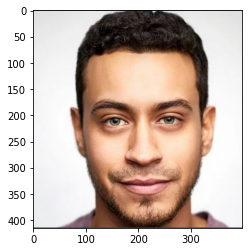

In [83]:
import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow

from matplotlib import pyplot as plt


from PIL import Image

img_path = 'unseen.jpg'
img_path = 'unseen2.png'
img_path = 'unseen3.jpg'
img_path = 'unseen4.jpg'
img_path = 'unseen5.jpg'
img_path = 'unseen10.jpg'
img_path = 'unseen11.jpg'
img_path = 'unseen12.jpg'


img = cv2.imread(img_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE,))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)
preds=model.predict(x)
print("predicted class: ", preds )

ind = np.argmax(preds)
clean = np.zeros(preds.shape)
clean[0][ind] = 1
print(clean)


In [ ]:
dic = {}
dic["7"] = "60-70_old"
dic["0"] = "0-10_old"
dic["1"] = "10-20_old"
dic["2"] = "100+_old" 
dic["3"] = "20-30_old"
dic["4"] = "30-40_old"
dic["5"] = "40-50_old"
dic["6"] = "50-60_old"
dic["8"] = "70-80_old"
dic["9"] = "80-90_old"
dic["10"] = "90-100_old"

_, idx = np.where(clean)
print(idx[0])

print(f"wiek osoby to {dic[str(idx[0])]}")

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "./modelage")